In [1]:
# Core imports and VoidX helpers
import os
import voidx  # ensure package import
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
from torch.utils.data import DataLoader
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN

from voidx.config import get_config
from voidx.data import GalaxyDataset, split_indices
from voidx.clustering import GalaxyClusteringAnalyzer
from voidx.models import TinyCNN, DeepResidualCNN
from voidx.utils import evaluate_model

# Enable LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # Adjust font size

# Configuration

In [2]:
from voidx.config import get_config

config = get_config(name='simulation_box2', param=None)  # picks up everything from config/global.json
# config = get_config(name='synthetic_void')  # picks up everything from config/global.json

# For backward compatibility, create variables from config
box = config.box
hdf = config.hdf
VIDE = config.VIDE
name = config.name
param = config.param
# Safe output filename component for param
param_str = str(param) if param else 'default'

fraction_in_voids = config.fraction_in_voids
N_neighbours = config.N_neighbours
box_size_mpc = config.box_size_mpc
void_size = config.void_size
model_name = config.model_name
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = config.seed

# Paths are automatically set up
data_dir = config.data_dir
param_dir = config.param_dir 
galaxy_info_dir = config.galaxy_info_dir
checkpoint_dir_spec = config.checkpoint_dir_spec
checkpoint_dir_global = config.checkpoint_dir_global
plot_dir = config.plot_dir
result_dir = config.result_dir

# Display configuration
config.print_info()

Loading global settings from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/config/config_global.json
Using device: mps
Notebook Configuration
Dataset: simulation_box2
Model name: simulation_box2_
Fraction in voids: 
Box: True, HDF: False, VIDE: False
Device: mps, Seed: 42
N neighbours: 20
Box size (Mpc/h): 60.0
Void size: 3.0
------------------------------------------------------------
Paths:
  data_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2
  param_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default
  galaxy_info_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files
  checkpoint_dir_spec: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/checkpoints
  checkpoint_dir_global: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/checkpoints
  plot_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/s

# Which model to use

In [3]:
if name == 'synthetic_void' :
     checkpoint_path = checkpoint_dir_global / f'best_model_{name}_N_neighbours{N_neighbours}_box{box_size_mpc}_void{void_size}.pth'
else :
    checkpoint_path = checkpoint_dir_global / f'best_model_{name}_N_neighbours{N_neighbours}.pth'

print(f"Checkpoint path: {checkpoint_path}")

Checkpoint path: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/checkpoints/best_model_simulation_box2_N_neighbours20.pth


# Load and process data

In [4]:
if name == 'synthetic_void':

    knn_file = galaxy_info_dir / f'galaxy_knn_{param_str}.npz'
    print(f"Loading k-NN data from: {knn_file}")

    with np.load(knn_file, allow_pickle=True) as data:
        print("Available keys:", list(data.keys()))
        positions = data['positions']
        membership = data['membership']
        first_neighbor_distances = data['first_neighbor_distances'] if 'first_neighbor_distances' in data else None
        void_centers = data['void_centers'] if 'void_centers' in data else None


        tensor_file = galaxy_info_dir / f'tensor_distances_{param_str}.npz'
        if tensor_file.exists():
            print(f"Found tensor file at: {tensor_file}")
            tensor_distance = np.load(tensor_file, mmap_mode='r')
            print("Loaded tensor from memory-mapped NPZ file.")
        else:
            raise FileNotFoundError("Tensor distance memory-mapped file not found.")

else:

    knn_file = galaxy_info_dir / f'galaxy_knn_N{N_neighbours}.npz'
    print(f"Loading k-NN data from: {knn_file}")

    with np.load(knn_file, allow_pickle=True) as data:
        print("Available keys:", list(data.keys()))
        positions = data['positions']
        membership = data['membership']
        first_neighbor_distances = data['first_neighbor_distances'] if 'first_neighbor_distances' in data else None
        void_centers = data['void_centers'] if 'void_centers' in data else None
        tensor_distance = data['tensor_distance'] if 'tensor_distance' in data else None

print("positions:", positions.shape)
print("membership:", membership.shape)
print("tensor_distance:", tensor_distance.shape) if tensor_distance is not None else print("tensor_distance: None")
print("first_neighbor_distances:", first_neighbor_distances.shape)

num_galaxies = positions.shape[0]
print(f"Number of galaxies: {num_galaxies}")
print('Number of voids:', len(void_centers) if void_centers is not None else 'N/A')

# Coordinates for geometry-based steps
X = positions.astype(np.float32)
y = membership.astype(np.float32)

Loading k-NN data from: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files/galaxy_knn_N20.npz
Available keys: ['positions', 'membership', 'first_neighbor_distances', 'void_centers', 'tensor_distance']
positions: (374460, 3)
membership: (374460,)
tensor_distance: (374460, 20, 20)
first_neighbor_distances: (374460, 20)
Number of galaxies: 374460
Number of voids: 200


In [5]:
# Prepare normalized features and DataLoader for inference
train_idx, val_idx, test_idx = split_indices(len(tensor_distance), train=0.7, val=0.15, seed=seed)
mean = tensor_distance[train_idx].mean(axis=0, keepdims=True)
std = tensor_distance[train_idx].std(axis=0, keepdims=True) + 1e-6
std[std == 0] = 1.0

X_normalized = ((tensor_distance - mean) / std).astype(np.float32)
X_all = X_normalized[:, None, :, :]  # add channel dimension
batch_size = 128
ds_all = GalaxyDataset(X_all, y)
dl_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Prepared dataset tensor shape: {X_all.shape}")
print(f"DataLoader batches: {len(dl_all)}")

Prepared dataset tensor shape: (374460, 1, 20, 20)
DataLoader batches: 2926


# Compute Guessed Probabilities
Use the trained DeepResidualCNN model to compute the guessed probabilities for the galaxies and store them in an array.

In [6]:
model = DeepResidualCNN(
    in_channels=1,
    widths=(32, 64, 128, 256),
    blocks_per_stage=(2, 2, 2, 2),
    block_dropout=0.10,
    fc_hidden=256,
    fc_dropout=0.30,
    use_se=True,
    ).to(device)

# model = TinyCNN(in_channels=1, c1=16, c2=32, dropout=0.2).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

eval_metrics = evaluate_model(model, dl_all, device=device)
probabilities = np.asarray(eval_metrics['probs'], dtype=np.float32)

# Save the guessed probabilities to a .npy file
output_path = result_dir / f'guessed_probabilities.npy'
np.save(output_path, probabilities)
print(f"Guessed probabilities saved to: {output_path}")

Model parameters: 2,883,553
Guessed probabilities saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/result/guessed_probabilities.npy


# Visualize Guessed Probabilities in 3D
Visualize the guessed probabilities in a 3D scatter plot using Matplotlib, with color representing the probability values.

In [7]:
# Use consistent probability thresholds for visualization
prob_low = 0.001
prob_high = 0.99

low_mask = probabilities < prob_low
high_mask = probabilities >= prob_high

low_positions = positions[low_mask]
high_positions = positions[high_mask]

# Save high-probability galaxies as a text file (x y z)
np.savetxt(result_dir / f'high_probability_galaxies.txt', high_positions, fmt='%.6f', header='x y z')

print('Number of galaxies with probabilities <', prob_low, ':', low_positions.shape[0])
print('Number of galaxies with probabilities ≥', prob_high, ':', high_positions.shape[0])

fig = go.Figure(data=[
    go.Scatter3d(
        x=high_positions[:, 0],
        y=high_positions[:, 1],
        z=high_positions[:, 2],
        mode='markers',
        marker=dict(size=2, color='green', opacity=0.8),
        name=f'Probabilities ≥ {prob_high}')
])

fig.update_layout(
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    ),
    title=f'3D Visualization of Galaxies with Probabilities < {prob_low} and ≥ {prob_high}',
    margin=dict(l=0, r=0, b=0, t=30),
    width=1000,
    height=800,
    legend=dict(title="Legend", itemsizing="constant")
)

# fig.show()
save_path = plot_dir / f'galaxies_high_probabilities_3d.html'
fig.write_html(save_path)
print(f"3D scatter plot saved to: {save_path}")

Number of galaxies with probabilities < 0.001 : 0
Number of galaxies with probabilities ≥ 0.99 : 2569
3D scatter plot saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/galaxies_high_probabilities_3d.html


# Clusters

Loaded 2569 galaxy coordinates from ndarray
GALAXY CLUSTERING ANALYSIS
Dataset: 2569 galaxies

Estimating natural clusters with DBSCAN:
  eps=0.1:   0 clusters, 100.0% noise
  eps=0.2:   0 clusters, 100.0% noise
  eps=0.3:   0 clusters, 100.0% noise
  eps=0.4:   1 clusters, 99.8% noise
  eps=0.5:   1 clusters, 99.8% noise
  eps=0.6:   2 clusters, 99.6% noise
  eps=0.7:   4 clusters, 99.2% noise
  eps=0.8:   5 clusters, 99.0% noise
  eps=0.9:   8 clusters, 98.4% noise
  eps=1.0:  12 clusters, 97.3% noise
  eps=1.1:  24 clusters, 94.8% noise
  eps=1.2:  36 clusters, 91.9% noise
  eps=1.3:  45 clusters, 89.4% noise
  eps=1.4:  55 clusters, 85.9% noise
  eps=1.5:  72 clusters, 81.0% noise
  eps=1.6:  88 clusters, 76.4% noise
  eps=1.7: 106 clusters, 71.6% noise
  eps=1.8: 119 clusters, 65.8% noise
  eps=1.9: 119 clusters, 62.0% noise
  eps=2.0: 127 clusters, 56.4% noise
  eps=2.1: 133 clusters, 52.4% noise
  eps=2.2: 141 clusters, 46.1% noise
  eps=2.3: 143 clusters, 40.7% noise
  eps=2.4:

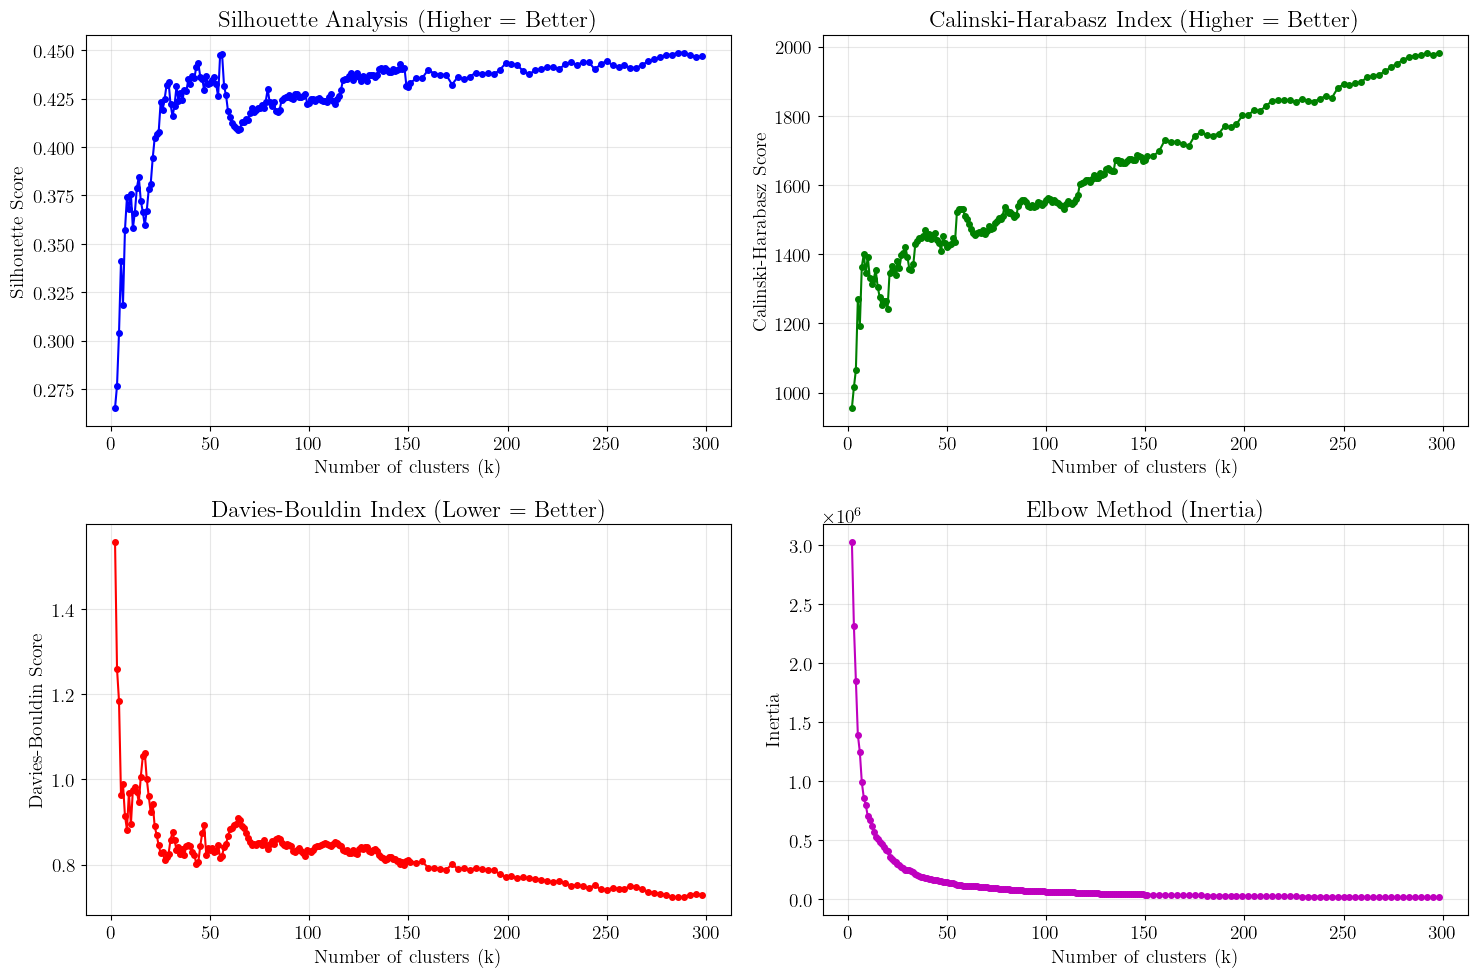


Optimization Results:
  Best k by Silhouette: 286 (score: 0.449)
  Best k by Calinski-Harabasz: 298 (score: 1983.2)
  Best k by Davies-Bouldin: 286 (score: 0.723)

FINAL ANALYSIS (k=298)

K-Means Results (k=298):
  Clusters: 298
  Silhouette Score: 0.447



DBSCAN Results (eps=3.3000000000000003, min_samples=5):
  Clusters: 124
  Noise points: 381 (14.8%)
  Silhouette Score: 0.466



ANALYSIS COMPLETE
Recommended configuration: K-Means with k=298
Natural clusters detected: 124 (DBSCAN eps=3.3000000000000003)

Final K-Means clustering metrics:
  n_points: 2569
  n_clusters: 298
  n_noise: 0
  noise_ratio: 0.0
  silhouette_score: 0.4467152401066188
  calinski_harabasz_score: 1983.1628566657457
  davies_bouldin_score: 0.7290986861472739

Best DBSCAN eps: 3.3000000000000003

DBSCAN Results (eps=3.3000000000000003, min_samples=5):
  Clusters: 124
  Noise points: 381 (14.8%)
  Silhouette Score: 0.466



K-Means Results (k=298):
  Clusters: 298
  Silhouette Score: 0.447


Number of clusters found by DBSCAN: 124
Number of clusters found by KMeans: 298
Number of true voids: 200


In [8]:
# Use 3D positions of high-probability galaxies
data = positions[high_mask]  # shape (n_high, 3)

n_high = data.shape[0]
if n_high < 3:
    raise ValueError(f"Not enough high-probability galaxies for clustering (need >= 3). Got {n_high}.")

# Initialize analyzer
analyzer = GalaxyClusteringAnalyzer(data, verbose=True)

# Run complete analysis (k is internally bounded by n_samples-1)
results = analyzer.run_complete_analysis(max_k=300, eps_range=np.arange(0.1, 10.0, 0.1))

# Access final kmeans metrics
final_kmeans = results["kmeans_optimized"]
print("\nFinal K-Means clustering metrics:")
for metric, value in final_kmeans["metrics"].items():
    if isinstance(value, dict):
        continue
    print(f"  {metric}: {value}")

eps_best = results["natural_estimate"]["eps"]
print(f"\nBest DBSCAN eps: {eps_best}")

dbscan_run = analyzer.run_dbscan(eps=eps_best, min_samples=5)
analyzer._plot_3d_clusters(
    dbscan_run["labels"],
    dbscan_run["centers"],
    title=f"DBSCAN (eps={eps_best})",
    # save_path=Path(plot_dir) / "dbscan_eps2.5.png",
    show=False,
 )

kmeans_run = analyzer.run_kmeans(n_clusters=len(results['kmeans_optimized']['centers']))
analyzer._plot_3d_clusters(
    kmeans_run["labels"],
    kmeans_run["centers"],
    title="K-Means Clustering (n_clusters={})".format(len(kmeans_run["centers"])),
    # save_path=Path(plot_dir) / "kmeans.png",
    show=False,
 )

print(f"Number of clusters found by DBSCAN: {len(dbscan_run['centers'])}")
print(f"Number of clusters found by KMeans: {len(kmeans_run['centers'])}")
try:
    n_voids = len(void_centers) if void_centers is not None else 'Unknown'
except NameError:
    n_voids = 'Unknown'
print(f"Number of true voids: {n_voids}")

# Construction of KMEANS voids with density contrast

Box dimensions: [74.84486  74.891335 74.916306]
Mean galaxy density: 0.891735 galaxies/Mpc³

Growing 298 voids simultaneously...
Starting radius: 1.0, Step: 0.1, Max: 10.0
Target δ = -0.5 ± 0.05

Step 20: Active voids mean R = 3.0 Mpc/h, δ range = [-0.989, -0.583], Converged = 148/298
Step 40: Active voids mean R = 5.0 Mpc/h, δ range = [-0.932, -0.561], Converged = 178/298
Step 60: Active voids mean R = 7.0 Mpc/h, δ range = [-0.897, -0.575], Converged = 209/298
Step 80: Active voids mean R = 9.0 Mpc/h, δ range = [-0.897, -0.557], Converged = 233/298

Final: 236/298 voids converged
Applied min_radius=2.000: kept 159/298 voids

Filtered void statistics:
  Total voids: 114
  Converged: 79/114
  Radius range: 2.00 - 10.00 Mpc/h
  Mean radius: 6.94 Mpc/h
  Median radius: 6.90 Mpc/h
  Density contrast range: -0.862 - -0.480
  Mean density contrast: -0.582


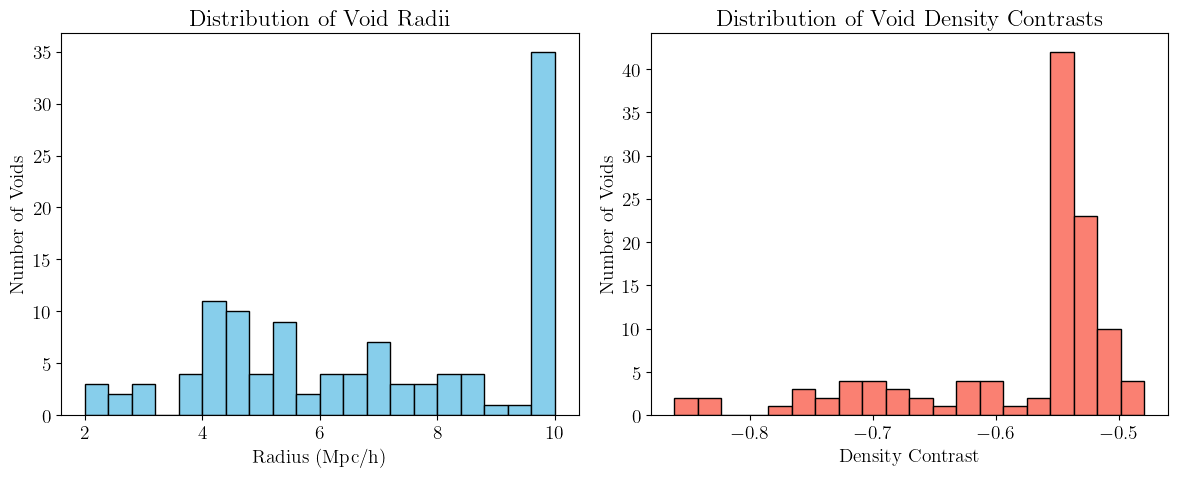

Void property distributions saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/void_property_distributions_kmeans.png


In [9]:
from voidx.reconstruction import * 

cluster_centers = results['kmeans_optimized']['centers']
# cluster_centers = dbscan_run["centers"]

# Compute mean density
box_dimensions = np.array([
    X[:, 0].max() - X[:, 0].min(),
    X[:, 1].max() - X[:, 1].min(),
    X[:, 2].max() - X[:, 2].min()
])
box_volume = np.prod(box_dimensions)
rho_mean = compute_mean_density(X, box_volume)

print(f"Box dimensions: {box_dimensions}")
print(f"Mean galaxy density: {rho_mean:.6f} galaxies/Mpc³\n")

# OPTION 2: Simultaneous growth (new, faster)
voids = grow_all_spheres_simultaneously(
    cluster_centers=cluster_centers,
    all_galaxies=X,
    rho_mean=rho_mean,
    initial_radius=1.0,      # Start small at void center
    radius_step=0.1,         # Grow by 0.1 Mpc/h
    max_radius=10.0,
    target_delta=-0.5,
    delta_tolerance=0.05
)

# Filter overlapping voids
filtered_voids_kmeans = filter_overlapping_voids(voids, overlap_threshold=0.5)

# Statistics
converged = [v for v in filtered_voids_kmeans if v['converged']]
radii = [v['radius'] for v in filtered_voids_kmeans]
deltas = [v['density_contrast'] for v in filtered_voids_kmeans]

print(f"\nFiltered void statistics:")
print(f"  Total voids: {len(filtered_voids_kmeans)}")
print(f"  Converged: {len(converged)}/{len(filtered_voids_kmeans)}")
print(f"  Radius range: {np.min(radii):.2f} - {np.max(radii):.2f} Mpc/h")
print(f"  Mean radius: {np.mean(radii):.2f} Mpc/h")
print(f"  Median radius: {np.median(radii):.2f} Mpc/h")
print(f"  Density contrast range: {np.min(deltas):.3f} - {np.max(deltas):.3f}")
print(f"  Mean density contrast: {np.mean(deltas):.3f}")

# Plot distributions of void properties
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
axes[0].hist(radii, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Void Radii')
axes[0].set_xlabel('Radius (Mpc/h)')
axes[0].set_ylabel('Number of Voids')
axes[1].hist(deltas, bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Void Density Contrasts')
axes[1].set_xlabel('Density Contrast')
axes[1].set_ylabel('Number of Voids')
plt.tight_layout()
plt.show()
save_path = plot_dir / "void_property_distributions_kmeans.png"
fig.savefig(save_path)
print(f"Void property distributions saved to: {save_path}")



In [10]:
# Visualization of reconstructed voids

print('Number of original voids centers: ', len(void_centers))
print('Number of reconstructed voids: ', len(filtered_voids_kmeans))

cluster_centers_kmeans = kmeans_run["centers"]
x_kmeans = []
y_kmeans = []
z_kmeans = []

for void in filtered_voids_kmeans:
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x_kmeans.append(void['radius'] * np.outer(np.cos(u), np.sin(v)) + void['center'][0])
    y_kmeans.append(void['radius'] * np.outer(np.sin(u), np.sin(v)) + void['center'][1])
    z_kmeans.append(void['radius'] * np.outer(np.ones(np.size(u)), np.cos(v)) + void['center'][2])

# Add reconstructed voids as spheres (Plotly)
fig_reconstructed = go.Figure()

if len(x_kmeans) == 0:
    print("No reconstructed void surfaces to plot (KMeans).")
else:
    for i, (sx, sy, sz) in enumerate(zip(x_kmeans, y_kmeans, z_kmeans)):
        fig_reconstructed.add_trace(
            go.Surface(
                x=sx, y=sy, z=sz,
                opacity=0.8,
                colorscale='Reds',
                showscale=False,
                name=f'Kmeans Void #{i}'
            )
        )

# Add original void centers
if void_centers is not None and len(void_centers) > 0:
    fig_reconstructed.add_trace(
        go.Scatter3d(
            x=void_centers[:, 0],
            y=void_centers[:, 1],
            z=void_centers[:, 2],
            mode='markers',
            marker=dict(size=6, color='black', symbol='x', opacity=1.0),
            name='Void Centers'
        )
    )

fig_reconstructed.update_layout(
    title=f'Reconstructed Voids (KMeans Centers, N = {len(x_kmeans)})',
    scene=dict(
        xaxis_title='X [Mpc/h]',
        yaxis_title='Y [Mpc/h]',
        zaxis_title='Z [Mpc/h]',
        aspectmode='cube'
    ),
    width=1000,
    height=800
)

# fig_reconstructed.show()
save_path  = plot_dir / f'reconstructed_voids_kmeans.html'
fig_reconstructed.write_html(save_path)
print(f"Reconstructed voids visualization saved to: {save_path}")

Number of original voids centers:  200
Number of reconstructed voids:  114
Reconstructed voids visualization saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/reconstructed_voids_kmeans.html


# Construction of DBSCAN voids with density contrast

Box dimensions: [74.84486  74.891335 74.916306]
Mean galaxy density: 0.891735 galaxies/Mpc³

Growing 124 voids simultaneously...
Starting radius: 1.0, Step: 0.1, Max: 10.0
Target δ = -0.5 ± 0.05

Step 20: Active voids mean R = 3.0 Mpc/h, δ range = [-0.989, -0.583], Converged = 42/124
Step 40: Active voids mean R = 5.0 Mpc/h, δ range = [-0.925, -0.593], Converged = 53/124
Step 60: Active voids mean R = 7.0 Mpc/h, δ range = [-0.875, -0.555], Converged = 75/124
Step 80: Active voids mean R = 9.0 Mpc/h, δ range = [-0.859, -0.552], Converged = 87/124

Final: 95/124 voids converged
Applied min_radius=2.000: kept 82/124 voids

Filtered void statistics:
  Total voids: 70
  Converged: 46/70
  Radius range: 3.10 - 10.00 Mpc/h
  Mean radius: 7.58 Mpc/h
  Median radius: 7.50 Mpc/h
  Density contrast range: -0.840 - -0.499
  Mean density contrast: -0.594


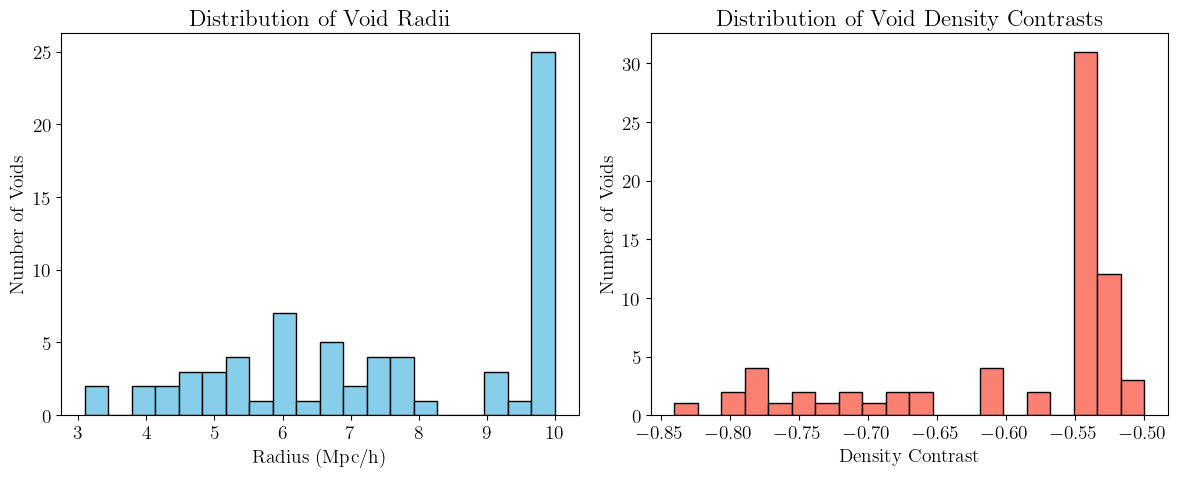

Void property distributions saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/void_property_distributions_dbscan.png


In [11]:
from voidx.reconstruction import * 

cluster_centers = dbscan_run["centers"]

# Compute mean density
box_dimensions = np.array([
    X[:, 0].max() - X[:, 0].min(),
    X[:, 1].max() - X[:, 1].min(),
    X[:, 2].max() - X[:, 2].min()
])
box_volume = np.prod(box_dimensions)
rho_mean = compute_mean_density(X, box_volume)

print(f"Box dimensions: {box_dimensions}")
print(f"Mean galaxy density: {rho_mean:.6f} galaxies/Mpc³\n")

# OPTION 2: Simultaneous growth (new, faster)
voids = grow_all_spheres_simultaneously(
    cluster_centers=cluster_centers,
    # cluster_centers=void_centers,
    all_galaxies=X,
    rho_mean=rho_mean,
    initial_radius=1.0,      # Start small at void center
    radius_step=0.1,         # Grow by 0.1 Mpc/h
    max_radius=10.0,
    target_delta=-0.5,
    delta_tolerance=0.05
)

# Filter overlapping voids
filtered_voids_dbscan = filter_overlapping_voids(voids, overlap_threshold=0.5)

# Statistics
converged = [v for v in filtered_voids_dbscan if v['converged']]
radii = [v['radius'] for v in filtered_voids_dbscan]
deltas = [v['density_contrast'] for v in filtered_voids_dbscan]

print(f"\nFiltered void statistics:")
print(f"  Total voids: {len(filtered_voids_dbscan)}")
print(f"  Converged: {len(converged)}/{len(filtered_voids_dbscan)}")
print(f"  Radius range: {np.min(radii):.2f} - {np.max(radii):.2f} Mpc/h")
print(f"  Mean radius: {np.mean(radii):.2f} Mpc/h")
print(f"  Median radius: {np.median(radii):.2f} Mpc/h")
print(f"  Density contrast range: {np.min(deltas):.3f} - {np.max(deltas):.3f}")
print(f"  Mean density contrast: {np.mean(deltas):.3f}")


# Plot distributions of void properties
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
axes[0].hist(radii, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Void Radii')
axes[0].set_xlabel('Radius (Mpc/h)')
axes[0].set_ylabel('Number of Voids')
axes[1].hist(deltas, bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Void Density Contrasts')
axes[1].set_xlabel('Density Contrast')
axes[1].set_ylabel('Number of Voids')
plt.tight_layout()
plt.show()
save_path = plot_dir / "void_property_distributions_dbscan.png"
fig.savefig(save_path)
print(f"Void property distributions saved to: {save_path}")


In [12]:
# Visualization of reconstructed voids

print('Number of original voids centers: ', len(void_centers))
print('Number of reconstructed voids: ', len(filtered_voids_dbscan))

cluster_centers_dbscan = dbscan_run["centers"]
x_dbscan = []
y_dbscan = []
z_dbscan = []
for void in filtered_voids_dbscan:
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x_dbscan.append(void['radius'] * np.outer(np.cos(u), np.sin(v)) + void['center'][0])
    y_dbscan.append(void['radius'] * np.outer(np.sin(u), np.sin(v)) + void['center'][1])
    z_dbscan.append(void['radius'] * np.outer(np.ones(np.size(u)), np.cos(v)) + void['center'][2])


fig_reconstructed = go.Figure()

if len(x_dbscan) == 0:
    print("No reconstructed void surfaces to plot (DBSCAN).")
else:
    for i, (sx, sy, sz) in enumerate(zip(x_dbscan, y_dbscan, z_dbscan)):
        fig_reconstructed.add_trace(
            go.Surface(
                x=sx, y=sy, z=sz,
                opacity=0.8,
                colorscale='Reds',
                showscale=False,
                name=f'DBSCAN Void #{i}'
            )
        )

# Add original void centers
if void_centers is not None and len(void_centers) > 0:
    fig_reconstructed.add_trace(
        go.Scatter3d(
            x=void_centers[:, 0],
            y=void_centers[:, 1],
            z=void_centers[:, 2],
            mode='markers',
            marker=dict(size=6, color='black', symbol='x', opacity=1.0),
            name='Void Centers'
        )
    )

fig_reconstructed.update_layout(
    title=f'Reconstructed Voids (DBSCAN Centers, N = {len(x_dbscan)})',
    scene=dict(
        xaxis_title='X [Mpc/h]',
        yaxis_title='Y [Mpc/h]',
        zaxis_title='Z [Mpc/h]',
        aspectmode='cube'
    ),
    width=1000,
    height=800
)

# fig_reconstructed.show()
save_path  = plot_dir / f'reconstructed_voids_dbscan.html'
fig_reconstructed.write_html(save_path)
print(f"Reconstructed voids visualization saved to: {save_path}")

Number of original voids centers:  200
Number of reconstructed voids:  70
Reconstructed voids visualization saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/reconstructed_voids_dbscan.html


# Compare KMEANS and DBSCAN voids 

/var/folders/5y/pmljdw295dxcvbx7r415frh00000gn/T/ipykernel_6451/3805026423.py:19: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



Comparison of reconstructed voids plot saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/comparison_reconstructed_voids.png


/Users/boccardpierre/.local/share/mamba/envs/astroenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



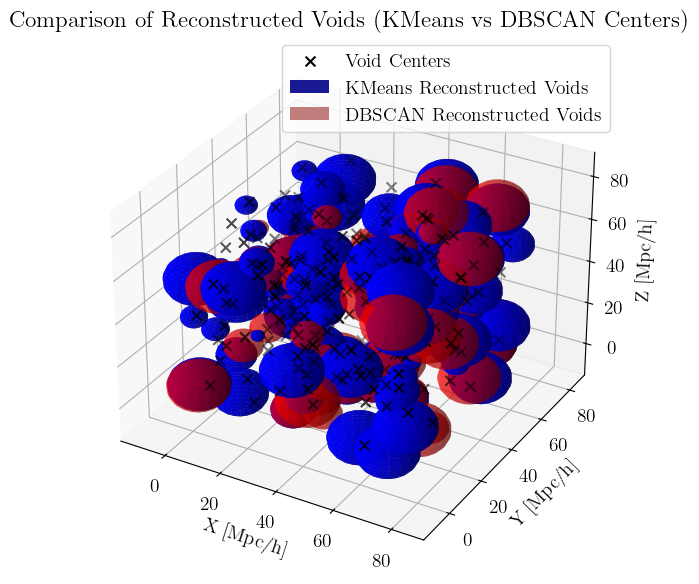

In [13]:
# Compare reconstructed voids with DBSCAN centers and KMeans centers

plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.scatter3D(void_centers[:, 0], void_centers[:, 1], void_centers[:, 2], color='black', marker='x', s=50)
ax.scatter3D(void_centers[0, 0], void_centers[0, 1], void_centers[0, 2], color='black', marker='x', s=50, label='Void Centers')
for i in range(len(x_kmeans)):
    ax.plot_surface(x_kmeans[i], y_kmeans[i], z_kmeans[i], color='blue', alpha=0.9)
ax.plot_surface(x_kmeans[i], y_kmeans[i], z_kmeans[i], color='blue', alpha=0.9, label='KMeans Reconstructed Voids')
for i in range(len(x_dbscan)):
    ax.plot_surface(x_dbscan[i], y_dbscan[i], z_dbscan[i], color='red', alpha=0.5)
ax.plot_surface(x_dbscan[i], y_dbscan[i], z_dbscan[i], color='red', alpha=0.5, label='DBSCAN Reconstructed Voids')
ax.set_title('Comparison of Reconstructed Voids (KMeans vs DBSCAN Centers)')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.legend()
save_path = plot_dir / "comparison_reconstructed_voids.png"
plt.savefig(save_path)
print(f"Comparison of reconstructed voids plot saved to: {save_path}")
plt.show()


In [14]:
# Compare reconstructed voids with DBSCAN centers and KMeans centers (Plotly)

cluster_centers_kmeans = kmeans_run["centers"]
cluster_centers_dbscan = dbscan_run["centers"]

fig_comparison = go.Figure()

# Add KMeans surfaces
if len(x_kmeans) == 0:
    print("No KMeans reconstructed surfaces to plot.")
else:
    for i, (sx, sy, sz) in enumerate(zip(x_kmeans, y_kmeans, z_kmeans)):
        fig_comparison.add_trace(
            go.Surface(
                x=sx, y=sy, z=sz,
                opacity=1,
                colorscale='Blues',
                showscale=False,
                name=f'KMeans Void #{i}'
            )
        )

# Add DBSCAN surfaces
if len(x_dbscan) == 0:
    print("No DBSCAN reconstructed surfaces to plot.")
else:
    for i, (sx, sy, sz) in enumerate(zip(x_dbscan, y_dbscan, z_dbscan)):
        fig_comparison.add_trace(
            go.Surface(
                x=sx, y=sy, z=sz,
                opacity=0.2,
                colorscale='Reds',
                showscale=False,
                name=f'DBSCAN Void #{i}'
            )
        )

# # Add original void centers for reference
# if void_centers is not None and len(void_centers) > 0:
#     fig_comparison.add_trace(
#         go.Scatter3d(
#             x=void_centers[:, 0],
#             y=void_centers[:, 1],
#             z=void_centers[:, 2],
#             mode='markers',
#             marker=dict(size=6, color='black', symbol='x', opacity=1.0),
#             name='Void Centers'
#         )
#     )

fig_comparison.update_layout(
    title='Comparison of Reconstructed Voids (KMeans vs DBSCAN)',
    scene=dict(
        xaxis_title='X [Mpc/h]',
        yaxis_title='Y [Mpc/h]',
        zaxis_title='Z [Mpc/h]',
        aspectmode='cube'
    ),
    width=900,
    height=700
)

# fig_comparison.show()
save_path  = plot_dir / f'comparison_reconstructed_voids.html'
fig_comparison.write_html(save_path)
print(f"Comparison of reconstructed voids visualization saved to: {save_path}")

Comparison of reconstructed voids visualization saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/comparison_reconstructed_voids.html


In [15]:
# Compare reconstructed voids with DBSCAN centers and KMeans centers (Plotly)

cluster_centers_kmeans = kmeans_run["centers"]
cluster_centers_dbscan = dbscan_run["centers"]

fig_comparison = go.Figure()

fig_comparison.add_trace(
    go.Scatter3d(
        x=cluster_centers_kmeans[:, 0],
        y=cluster_centers_kmeans[:, 1],
        z=cluster_centers_kmeans[:, 2],
        mode='markers',
        marker=dict(size=6, color='blue', symbol='diamond', opacity=1.0),
        name='KMeans Void Centers'
    )
)

fig_comparison.add_trace(
    go.Scatter3d(
        x=cluster_centers_dbscan[:, 0],
        y=cluster_centers_dbscan[:, 1],
        z=cluster_centers_dbscan[:, 2],
        mode='markers',
        marker=dict(size=6, color='red', symbol='circle', opacity=1.0),
        name='DBSCAN Void Centers'
    )
)

# Add original void centers for reference
if void_centers is not None and len(void_centers) > 0:
    fig_comparison.add_trace(
        go.Scatter3d(
            x=void_centers[:, 0],
            y=void_centers[:, 1],
            z=void_centers[:, 2],
            mode='markers',
            marker=dict(size=6, color='black', symbol='x', opacity=0.4),
            name='Void Centers'
        )
    )

fig_comparison.update_layout(
    title='Comparison of Reconstructed Voids (KMeans vs DBSCAN)',
    scene=dict(
        xaxis_title='X [Mpc/h]',
        yaxis_title='Y [Mpc/h]',
        zaxis_title='Z [Mpc/h]',
        aspectmode='cube'
    ),
    width=900,
    height=700
)

# fig_comparison.show()
save_path  = plot_dir / f'comparison_reconstructed_center_voids.html'
fig_comparison.write_html(save_path)
print(f"Comparison of reconstructed voids visualization saved to: {save_path}")

Comparison of reconstructed voids visualization saved to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/comparison_reconstructed_center_voids.html
